# Manipulation avancée d'images : masques et composition

Ce chapitre explore des techniques avancées pour manipuler des images, y compris l'extraction de régions spécifiques via des masques et la fusion de plusieurs images ensemble.

---

## Concepts clés

- **Masquage d'images** : isoler des régions spécifiques
- **Opérations morphologiques** : transformations binaires des images
- **Composition d'images** : fusion de plusieurs images
- **Traitement des canaux** : application de filtres par canal

In [3]:
# Importation des bibliothèques nécessaires
import numpy as np
from scipy.ndimage import (gaussian_filter, binary_closing, binary_opening, 
                          binary_erosion, binary_dilation)
from skimage import io, transform
import matplotlib.pyplot as plt

---

## Chargement et redimensionnement d'images

Avant de fusionner des images, elles doivent avoir les mêmes dimensions. Le redimensionnement (resampling) permet d'ajuster la taille d'une image à une autre.

Dimensions de just_do_it: (917, 1630, 3)
Dimensions de fire: (1960, 2504, 3)
Plage de valeurs just_do_it: 0 à 255
Plage de valeurs fire: 0 à 255


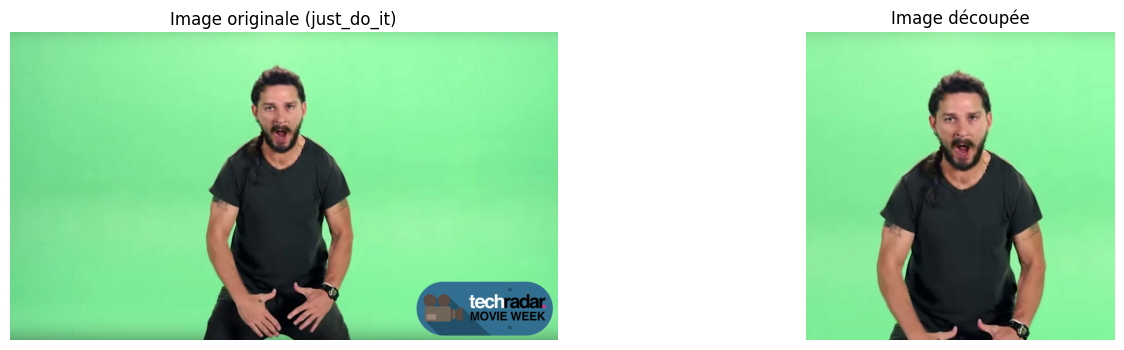

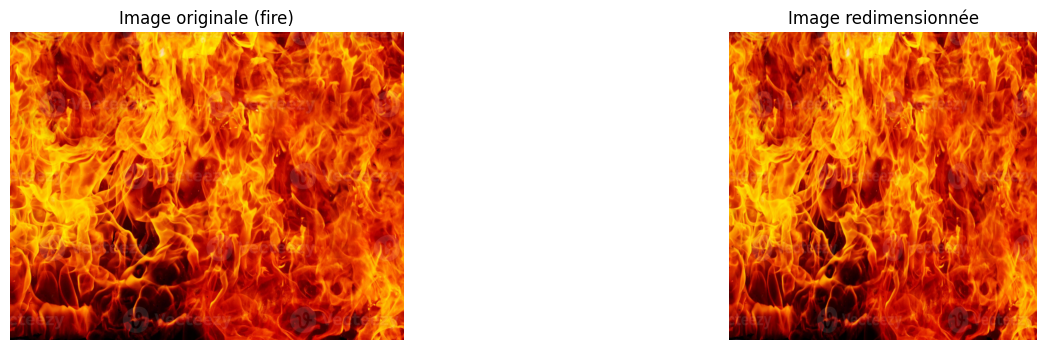

Dimensions finales: (800, 800, 3) (800, 800, 3)


In [4]:
# Charger deux images depuis des fichiers
just_do_it = io.imread('data/just_do_it.jpg')
fire = io.imread('data/fire.jpg')

# Afficher les dimensions et gammes de valeurs
print('Dimensions de just_do_it:', just_do_it.shape)
print('Dimensions de fire:', fire.shape)
print('Plage de valeurs just_do_it:', np.min(just_do_it), 'à', np.max(just_do_it))
print('Plage de valeurs fire:', np.min(fire), 'à', np.max(fire))

# Cropper (découper) la première image pour une meilleure composition
fig, axs = plt.subplots(1, 2, figsize=(16, 4))
axs[0].imshow(just_do_it)
axs[0].set_title("Image originale (just_do_it)")
axs[0].axis('off')

# Extraire une région rectangulaire : [ligne_min:ligne_max, colonne_min:colonne_max]
just_do_it_crop = just_do_it[0:800, 400:1200]
axs[1].imshow(just_do_it_crop)
axs[1].set_title("Image découpée")
axs[1].axis('off')

plt.show()

# Redimensionner la deuxième image pour qu'elle corresponde à la première
# transform.resize retourne des valeurs entre 0 et 1, donc on les multiplie par 255
fire_resize = (transform.resize(fire, (800, 800)) * 255).astype(np.uint8)

fig, axs = plt.subplots(1, 2, figsize=(16, 4))
axs[0].imshow(fire)
axs[0].set_title("Image originale (fire)")
axs[0].axis('off')

axs[1].imshow(fire_resize)
axs[1].set_title("Image redimensionnée")
axs[1].axis('off')

plt.show()

print('Dimensions finales:', just_do_it_crop.shape, fire_resize.shape)

---

## Exploration des canaux RGB

Pour isoler des régions spécifiques, nous explorons les canaux individuels et cherchons celui qui offre le meilleur contraste.

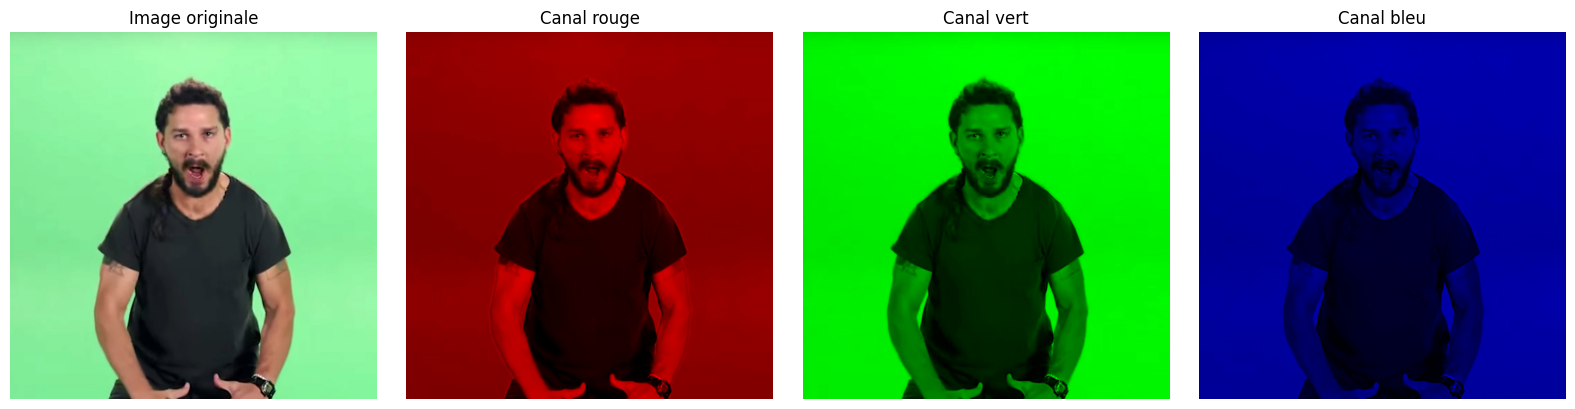

In [5]:
# Afficher les trois canaux RGB de l'image découpée
fig, axs = plt.subplots(1, 4, figsize=(16, 4))

# Image originale
axs[0].imshow(just_do_it_crop)
axs[0].set_title("Image originale")
axs[0].axis('off')

# Canal rouge uniquement
tmp_arr = just_do_it_crop.copy()
tmp_arr[:,:,1:3] = 0
axs[1].imshow(tmp_arr)
axs[1].set_title("Canal rouge")
axs[1].axis('off')

# Canal vert uniquement
tmp_arr = just_do_it_crop.copy()
tmp_arr[:,:,0:3:2] = 0
axs[2].imshow(tmp_arr)
axs[2].set_title("Canal vert")
axs[2].axis('off')

# Canal bleu uniquement
tmp_arr = just_do_it_crop.copy()
tmp_arr[:,:,0:2] = 0
axs[3].imshow(tmp_arr)
axs[3].set_title("Canal bleu")
axs[3].axis('off')

fig.tight_layout()
plt.show()

---

## Création de masques par seuillage

Le canal vert offre souvent le meilleur contraste pour isoler des régions (technique du "green screen"). En appliquant un seuil, on crée un **masque binaire**.

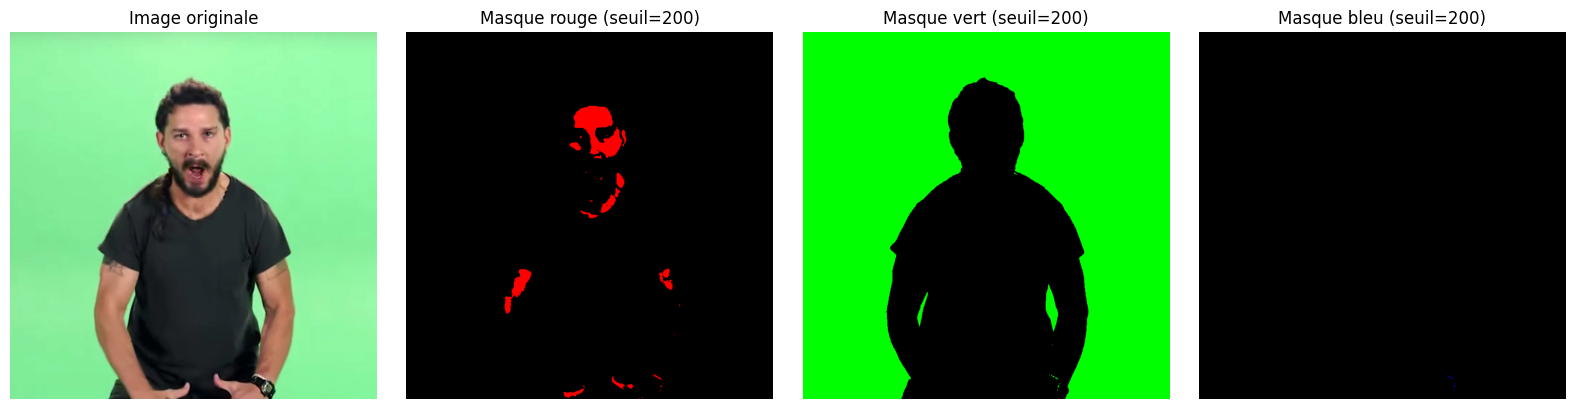

In [6]:
# Créer des masques en utilisant le seuillage sur chaque canal
fig, axs = plt.subplots(1, 4, figsize=(16, 4))

# Image originale
axs[0].imshow(just_do_it_crop)
axs[0].set_title("Image originale")
axs[0].axis('off')

# Masque du canal rouge - pixels < 200 deviennent noir, >= 200 deviennent blanc
tmp_arr = just_do_it_crop.copy()
tmp_arr[:,:,1:3] = 0  # Supprimer les autres canaux
tmp_arr[tmp_arr < 200] = 0
tmp_arr[tmp_arr >= 200] = 255
axs[1].imshow(tmp_arr)
axs[1].set_title("Masque rouge (seuil=200)")
axs[1].axis('off')

# Masque du canal vert
tmp_arr = just_do_it_crop.copy()
tmp_arr[:,:,0:3:2] = 0  # Supprimer les canaux rouge et bleu
tmp_arr[tmp_arr < 200] = 0
tmp_arr[tmp_arr >= 200] = 255
axs[2].imshow(tmp_arr)
axs[2].set_title("Masque vert (seuil=200)")
axs[2].axis('off')

# Masque du canal bleu
tmp_arr = just_do_it_crop.copy()
tmp_arr[:,:,0:2] = 0  # Supprimer les canaux rouge et vert
tmp_arr[tmp_arr < 200] = 0
tmp_arr[tmp_arr >= 200] = 255
axs[3].imshow(tmp_arr)
axs[3].set_title("Masque bleu (seuil=200)")
axs[3].axis('off')

fig.tight_layout()
plt.show()

---

## Opérations morphologiques : affinage des masques

Les opérations morphologiques comme **binary_opening** et **binary_dilation** permettent de nettoyer et d'améliorer les masques en supprimant le bruit et en remplissant les trous.

Dimensions du masque inverse: (800, 800)


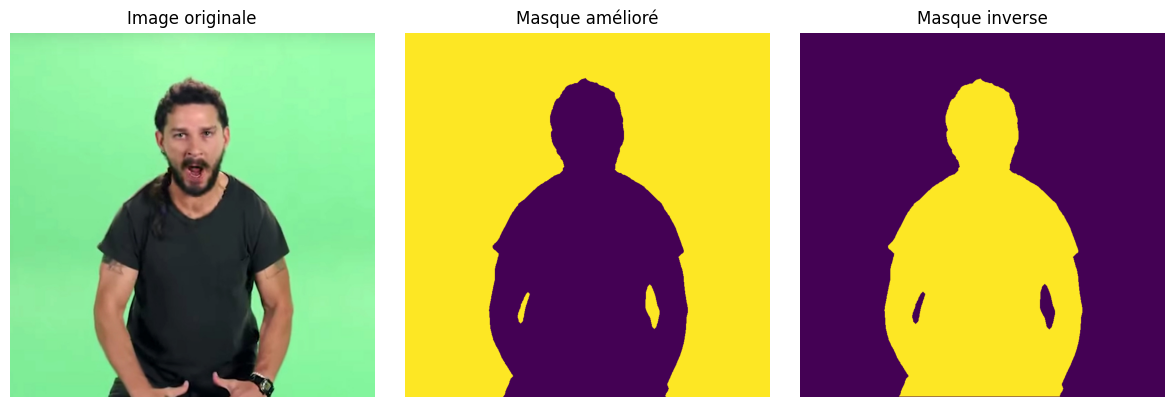

In [7]:
# Générer un masque amélioré à partir du canal vert
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Afficher l'image originale
axs[0].imshow(just_do_it_crop)
axs[0].set_title("Image originale")
axs[0].axis('off')

# Créer le masque du canal vert
tmp_arr = just_do_it_crop.copy()
tmp_arr[:,:,0:3:2] = 0
tmp_arr[tmp_arr < 200] = 0
tmp_arr[tmp_arr >= 200] = 255

# Convertir en booléen pour les opérations morphologiques
mask = np.sum(tmp_arr, axis=-1)

# Appliquer binary_opening pour supprimer les petites régions bruitées
# Ensuite binary_dilation pour remplir les trous et dilater les régions
mask = binary_dilation(binary_opening(mask, iterations=2), iterations=2)

axs[1].imshow(mask)
axs[1].set_title("Masque amélioré")
axs[1].axis('off')

# Créer le masque inverse (inverse logique du masque)
inverted_mask = binary_erosion(np.invert(mask), iterations=1)
print('Dimensions du masque inverse:', inverted_mask.shape)

axs[2].imshow(inverted_mask)
axs[2].set_title("Masque inverse")
axs[2].axis('off')

fig.tight_layout()
plt.show()

---

## Application des masques aux images

Les masques sont appliqués en multipliant l'image par le masque. Cela conserve les régions où le masque vaut 1 et supprime les régions où il vaut 0.

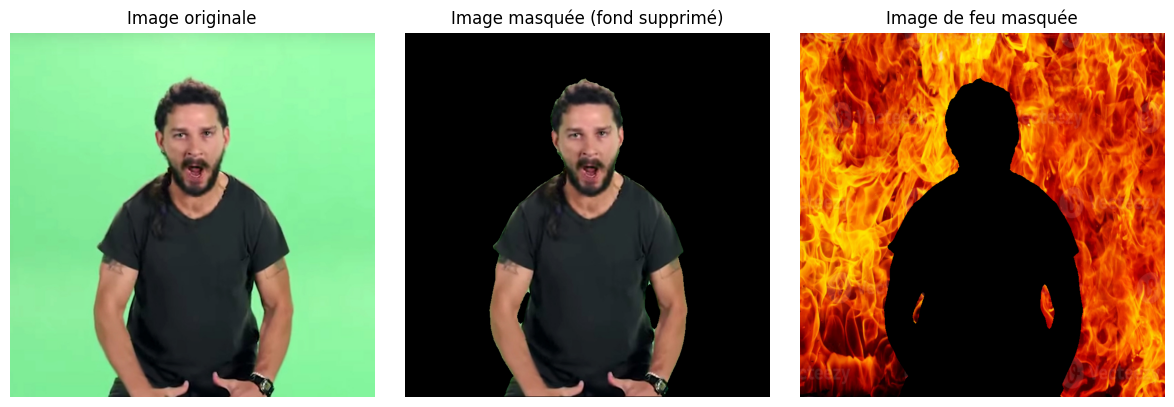

In [8]:
# Appliquer les masques à chaque image
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Afficher l'image originale
axs[0].imshow(just_do_it_crop)
axs[0].set_title("Image originale")
axs[0].axis('off')

# Appliquer le masque inverse à just_do_it
# np.expand_dims ajoute une dimension pour faire correspondre les canaux RGB
just_do_it_masked = np.expand_dims(inverted_mask, axis=-1) * just_do_it_crop
axs[1].imshow(just_do_it_masked.astype(np.uint8))
axs[1].set_title("Image masquée (fond supprimé)")
axs[1].axis('off')

# Appliquer le masque direct à fire (conserver l'intérieur du masque)
fire_masked = np.expand_dims(mask, axis=-1) * fire_resize
axs[2].imshow(fire_masked.astype(np.uint8))
axs[2].set_title("Image de feu masquée")
axs[2].axis('off')

fig.tight_layout()
plt.show()

---

## Fusion d'images (blending)

La fusion combine deux images masquées en les additionnant. Important : le filtre gaussien doit être appliqué à chaque canal indépendamment pour préserver la structure de couleur.

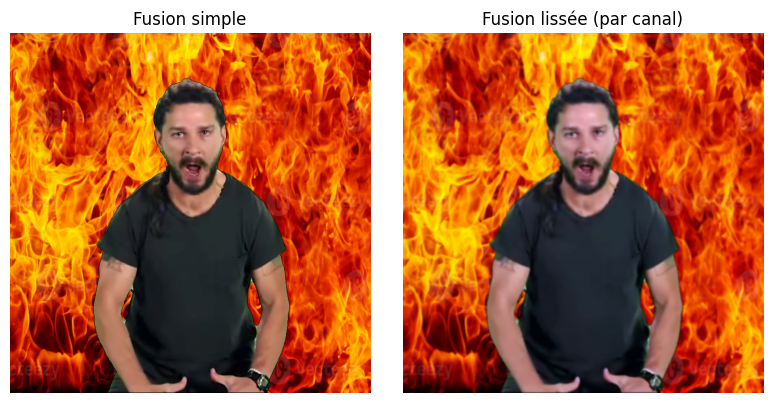

In [9]:
# Fusion simple des deux images masquées
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

# Fusion sans lissage préalable
blending = fire_masked + just_do_it_masked
blending = blending / blending.max()  # Normaliser entre 0 et 1
blending = (blending * 255).astype(np.uint8)
axs[0].imshow(blending)
axs[0].set_title("Fusion simple")
axs[0].axis('off')

# Fusion avec lissage sur tous les canaux indépendamment
# Attention : appliquer gaussian_filter directement sur une image 3D lisse les canaux ensemble
# Solution : lisser chaque canal séparément
blending_smooth = np.zeros((800, 800, 3))
for i in range(3):
    # Lisser chaque canal indépendamment avec sigma=1
    blending_smooth[:,:,i] = (gaussian_filter(fire_masked[:,:,i], sigma=1) + 
                              gaussian_filter(just_do_it_masked[:,:,i], sigma=1))
    # Normaliser et lisser à nouveau
    blending_smooth[:,:,i] = gaussian_filter(blending_smooth[:,:,i] / 
                                            (blending_smooth[:,:,i].max() + 1e-6), sigma=1)

blending_smooth = (blending_smooth * 255).astype(np.uint8)
axs[1].imshow(blending_smooth)
axs[1].set_title("Fusion lissée (par canal)")
axs[1].axis('off')

fig.tight_layout()
plt.show()